In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from torchvision import models
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

In [2]:
batch_size = 32
IMG_SIZE = [224,224]
num_classes = 42
device = "cuda"

In [3]:
transform = transforms.Compose(
    [transforms.Resize(IMG_SIZE),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainvalset = torchvision.datasets.ImageFolder("train/train/",transform=transform)
print(len(trainvalset))

trainset, valset = torch.utils.data.random_split(trainvalset, [len(trainvalset)-30000, 30000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.ImageFolder("test/",transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

105392


tensor([40, 20, 34, 36, 15, 10, 28, 35,  2, 41, 39, 31, 12, 37, 28, 12,  1,  9,
        23, 19,  0, 10, 37, 31, 19, 26,  8,  8, 13, 32,  8,  3])


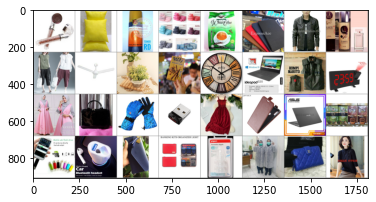

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model.load_state_dict(torch.load("resnet.pth"))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
print(model)



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def evaluate(net):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(valloader)
        for data in pbar:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar.set_description("Val Accuracy %.2f" % (correct/float(total)))

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [ ]:
print("Started Training")
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0
        #if i % 200 == 199:
    evaluate(model)
    model.train()
    torch.save(model.state_dict(), "resnet.pth")

print('Finished Training')

Started Training
[1,    20] loss: 0.891
[1,    40] loss: 0.759
[1,    60] loss: 0.803
[1,    80] loss: 0.769
[1,   100] loss: 0.818
[1,   120] loss: 0.740
[1,   140] loss: 0.776
[1,   160] loss: 0.819
[1,   180] loss: 0.740
[1,   200] loss: 0.771
[1,   220] loss: 0.792
[1,   240] loss: 0.762
[1,   260] loss: 0.853
[1,   280] loss: 0.775
[1,   300] loss: 0.811
[1,   320] loss: 0.839
[1,   340] loss: 0.810
[1,   360] loss: 0.901
[1,   380] loss: 0.836
[1,   400] loss: 0.870
[1,   420] loss: 0.791
[1,   440] loss: 0.810
[1,   460] loss: 0.710
[1,   480] loss: 0.826
[1,   500] loss: 0.778
[1,   520] loss: 0.824
[1,   540] loss: 0.819
[1,   560] loss: 0.749
[1,   580] loss: 0.716
[1,   600] loss: 0.896
[1,   620] loss: 0.846
[1,   640] loss: 0.841
[1,   660] loss: 0.788
[1,   680] loss: 0.748
[1,   700] loss: 0.816
[1,   720] loss: 0.798
[1,   740] loss: 0.897
[1,   760] loss: 0.783
[1,   780] loss: 0.797
[1,   800] loss: 0.839
[1,   820] loss: 0.719
[1,   840] loss: 0.792
[1,   860] loss: 

Val Accuracy 0.81: 100%|██████████| 938/938 [05:53<00:00,  2.65it/s]

Accuracy of the network on the 10000 test images: 80 %


[2,    20] loss: 0.741
[2,    40] loss: 0.672
[2,    60] loss: 0.748
[2,    80] loss: 0.727
[2,   100] loss: 0.766
[2,   120] loss: 0.756
[2,   140] loss: 0.775
[2,   160] loss: 0.709
[2,   180] loss: 0.781
[2,   200] loss: 0.715
[2,   220] loss: 0.751
[2,   240] loss: 0.783
[2,   260] loss: 0.703
[2,   280] loss: 0.781
[2,   300] loss: 0.759
[2,   320] loss: 0.742
[2,   340] loss: 0.768
[2,   360] loss: 0.739
[2,   380] loss: 0.795
[2,   400] loss: 0.841
[2,   420] loss: 0.780
[2,   440] loss: 0.767
[2,   460] loss: 0.762
[2,   480] loss: 0.765
[2,   500] loss: 0.707
[2,   520] loss: 0.881
[2,   540] loss: 0.742
[2,   560] loss: 0.816
[2,   580] loss: 0.722
[2,   600] loss: 0.697
[2,   620] loss: 0.773
[2,   640] loss: 0.716
[2,   660] loss: 0.773
[2,   680] loss: 0.820
[2,   700] loss: 0.696
[2,   720] loss: 0.732
[2,   740] loss: 0.787
[2,   760] loss: 0.659
[2,   780] loss: 0.682
[2,   800] loss: 0.773
[2,   820] loss: 0.728
[2,   840] loss: 0.746
[2,   860] loss: 0.782
[2,   880] 